# 处理图片

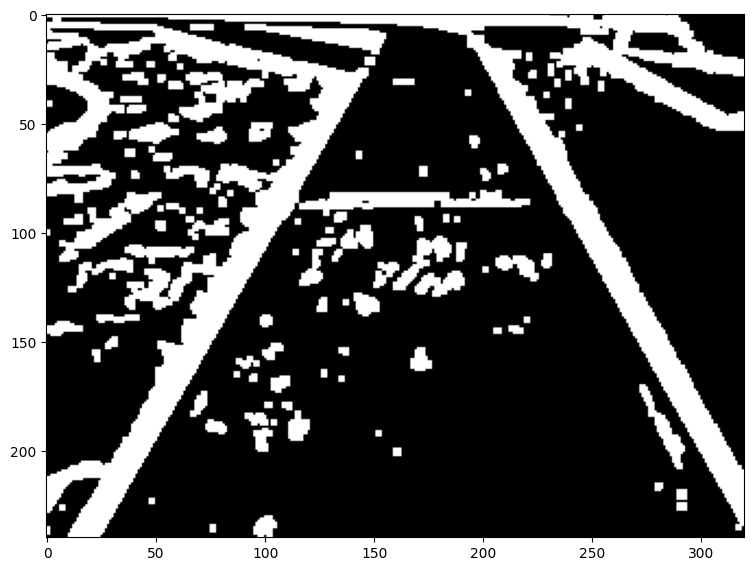

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def filter(binary):
    binary = cv2.dilate(binary, np.ones((3, 3), np.uint8), iterations=1)  # 膨胀操作
    binary = cv2.erode(binary, np.ones((3, 3), np.uint8), iterations=1)   # 腐蚀操作
    return binary


def sobel_filter(binary):
    sobelx = cv2.Sobel(binary, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(binary, cv2.CV_64F, 0, 1, ksize=3)
    result = np.sqrt(sobelx**2 + sobely**2)
    result = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    return result

def watershed_filter(binary):
    # # 分水岭算法
    # ret, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # 形态学开运算去噪
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    # 获取确定的背景区域
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # 获取确定的前景区域（通过距离变换）
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # 未知区域 = 背景 - 前景
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    # 标记连通区域
    ret, markers = cv2.connectedComponents(sure_fg)

    # 所有标签加1，背景为1
    markers = markers + 1

    # 将“未知区域”标记为0
    markers[unknown == 255] = 0
    markers = cv2.watershed(img, markers)
    return markers
    # 分水岭分界线像素会被标记为 -1 
    

def process_frame(frame):
    image = frame   
    image = cv2.resize(image, (320, 240))  # 缩小图像以加快处理速度
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # 转换为灰度图
    binary = cv2.adaptiveThreshold(
        image,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=35,     # 邻域大小（建议奇数）
        C=5               # 调整偏移值
    )
    
    # 形态学滤波
    # binary = filter(binary)
    # 搜索连通域
    binary = cv2.morphologyEx(binary, cv2.MORPH_ERODE, np.ones((3, 3), np.uint8))
    # binary = get_the_road(binary)
    # markers = watershed_filter(binary)
    binary = 255 - binary
    # 分水岭分界线像素会被标记为 -1
    result = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)  # 转回 BGR 格式
    # result[markers == -1] = [0, 0, 255]  # 用红色画出边界
    frame = result
    return frame


# 输入文件路径
file_name = "frame_0050"
input_file = f'./result/frames_output/exp1/{file_name}.png'
output_file = f'./result/{file_name}_pro.png'
    
img = cv2.imread(input_file)
if img is None:
    print("con not read the image")
else:
    result = process_frame(img)
    cv2.imwrite(output_file, result)
    plt.figure(figsize=(9,9))
    plt.imshow(result)
    plt.show()


# 计算图片方差

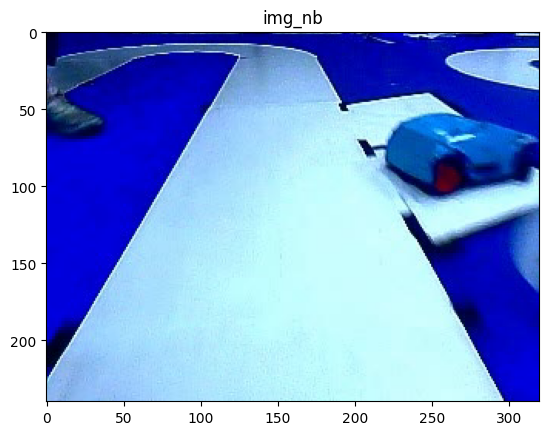

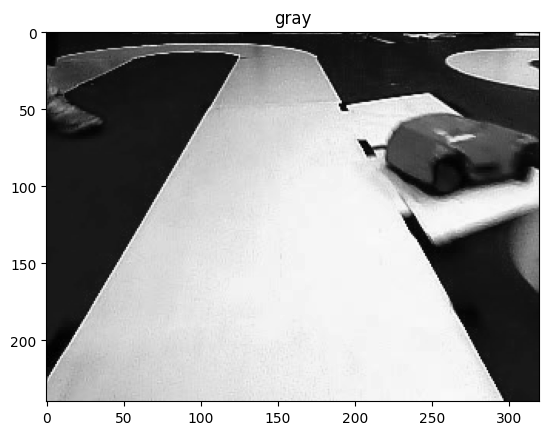

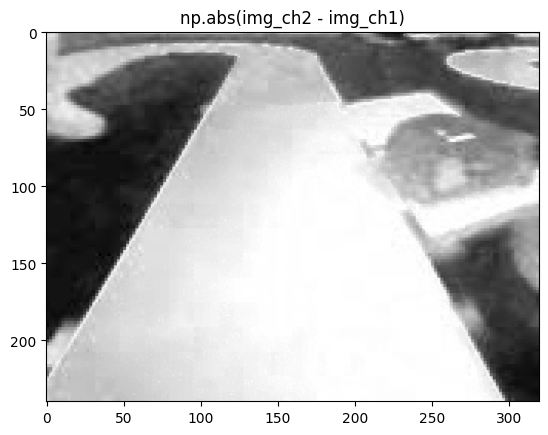

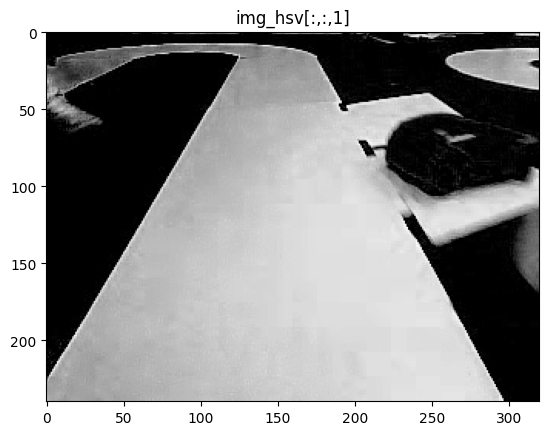

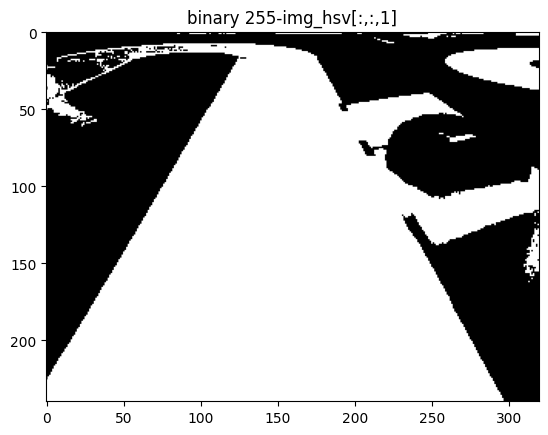

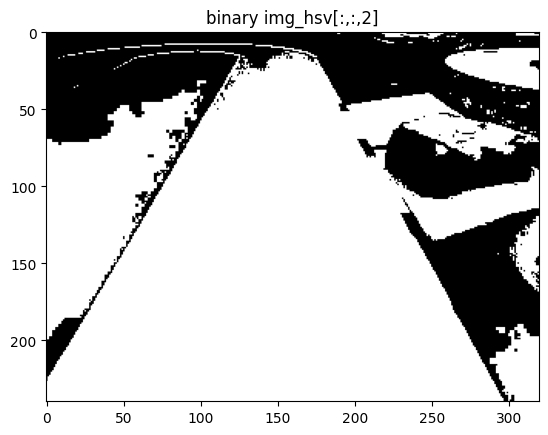

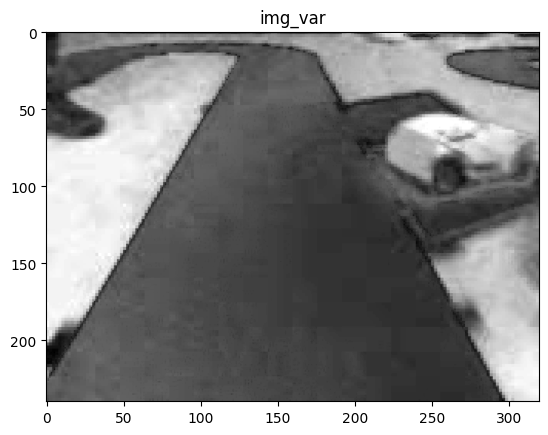

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# # 计算图片像素不同颜色通道的的方差值
# def cal_the_variance(img):
#     img_shape = img[:,:,0].shape
#     img_var = np.zeros(img_shape, dtype=np.float32)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.int16)
#     img_ch0 = img[:,:,0].astype(np.int16)
#     img_ch1 = img[:,:,1].astype(np.int16)
#     img_ch2 = img[:,:,2].astype(np.int16)
#     plt.imshow(gray)
#     plt.show()
#     img_var = np.abs(img_ch0 - gray) + np.abs(img_ch1 - gray) + np.abs(img_ch2 - gray)
#     # img_var = np.clip(img_var, 0, 255)
#     ret = img_var.astype(np.uint8) * 10
#     # print(ret)
#     return ret

# 读取图像（灰度方式）
img = cv2.imread('result/frames_output/sample/frame_0048.png')
img = cv2.resize(img, (320, 240))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = img[:,:,2]
# 二值化（如果已经是二值图可以跳过）
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
img_nb = img.copy()
# img_nb[:,:,0] = 0
plt.title("img_nb")
plt.imshow(img_nb)
plt.show()
img_hsv = cv2.cvtColor(img_nb, cv2.COLOR_RGB2HSV)
img_shape = img[:,:,0].shape
img_var = np.zeros(img_shape, dtype=np.float32)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.int16)
img_ch0 = img[:,:,0].astype(np.int16)
img_ch1 = img[:,:,1].astype(np.int16)
img_ch2 = img[:,:,2].astype(np.int16)
plt.title("gray")
plt.imshow(gray, cmap='gray')
plt.show()
plt.title("np.abs(img_ch2 - img_ch1)")
plt.imshow(255-np.abs(img_ch2 - img_ch1), cmap='gray')
plt.show()
plt.title("img_hsv[:,:,1]")
plt.imshow(255-img_hsv[:,:,1], cmap='gray')
plt.show()

# 大津法
ret, binary = cv2.threshold(255-img_hsv[:,:,1], 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.title("binary 255-img_hsv[:,:,1]")
plt.imshow(binary, cmap='gray')
plt.show()
plt.title("binary img_hsv[:,:,2]")
ret, binary = cv2.threshold(img_hsv[:,:,2], 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(binary, cmap='gray')
plt.show()
# img_var = np.abs(img_ch0 - gray) + np.abs(img_ch1 - gray) + np.abs(img_ch2 - gray)
img_gray = gray.astype(np.int16)
img_var = np.abs(img_ch0 - img_gray) + np.abs(img_ch1 - img_gray) + np.abs(img_ch2 - img_gray)
img_var = np.clip(img_var, 0, 255)
img_var = img_var.astype(np.uint8)
# img_var = img_var.astype(np.uint8) * 10
plt.title("img_var")
plt.imshow(img_var, cmap='gray')
plt.show()

# 处理视频

In [82]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def filter(binary):
    binary = cv2.dilate(binary, np.ones((3, 3), np.uint8), iterations=1)  # 膨胀操作
    binary = cv2.erode(binary, np.ones((3, 3), np.uint8), iterations=1)   # 腐蚀操作
    return binary


def region_growing(gray, seed, threshold=10):
    h, w = gray.shape
    visited = np.zeros_like(gray, dtype=bool)
    result = np.zeros_like(gray, dtype=np.uint8)

    # 初始化生长队列
    seed_val = gray[seed[1], seed[0]]
    stack = [seed]
    visited[seed[1], seed[0]] = True

    # 8邻域
    neighbors = [(-1, -1), (-1, 0), (-1, 1),
                 ( 0, -1),          ( 0, 1),
                 ( 1, -1), ( 1, 0), ( 1, 1)]

    while stack:
        x, y = stack.pop()
        result[y, x] = 255  # 标记当前点为区域内

        for dx, dy in neighbors:
            nx, ny = x + dx, y + dy
            if (0 <= nx < w) and (0 <= ny < h) and not visited[ny, nx]:
                if abs(int(gray[ny, nx]) - int(seed_val)) < threshold:
                    stack.append((nx, ny))
                    visited[ny, nx] = True

    return result

# def get_the_road(binary):
#     # 分水岭算法
#     seed = (160, 230)
#     result = region_growing(binary, seed, threshold=10)
#     return result


def sobel_filter(binary):
    sobelx = cv2.Sobel(binary, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(binary, cv2.CV_64F, 0, 1, ksize=3)
    result = np.sqrt(sobelx**2 + sobely**2)
    result = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    return result

# def watershed_filter(binary):
#     markers = np.zeros(img.shape[:2], dtype=np.int32)
#     markers[binary > 0] = 1
#     cv2.watershed(binary, markers)
#     markers = markers.astype(np.uint8)
#     return markers

def kmeans_segmentation(image, K=3):
    # 将图像转换为二维数组
    Z = image.reshape((-1, 3))
    Z = np.float32(Z)

    # 定义 K 均值聚类的参数
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # 将中心点转换为 uint8 类型
    center = np.uint8(center)
    result = center[label.flatten()]
    result = result.reshape(image.shape)

    return result

# 计算图片像素不同颜色通道的的方差值
def cal_the_variance(img_rgb):
    img_shape = img_rgb[:,:,0].shape
    img_var = np.zeros(img_shape, dtype=np.float32)
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    gray = gray.astype(np.int16)
    img_ch0 = img_rgb[:,:,0].astype(np.int16)
    img_ch1 = img_rgb[:,:,1].astype(np.int16)
    img_ch2 = img_rgb[:,:,2].astype(np.int16)
    img_var = (np.abs(img_ch0 - gray) + np.abs(img_ch1 - gray) + np.abs(img_ch2 - gray))
    img_var = np.divide(img_var, gray+1)
    img_var = img_var * 200
    img_var = 255 - np.clip(img_var, 0, 255)
    img_var = img_var.astype(np.uint8)
    # ret = img_var.astype(np.uint8) * 10
    # print(ret)
    return img_var

def get_the_road(binary):
    # 分水岭算法
    # seed = (160, 220)
    # result = region_growing(binary, seed, threshold=10)
    # 开运算
    # binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    # binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    # binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
    # 腐蚀
    # binary = cv2.morphologyEx(binary, cv2.MORPH_ERODE, np.ones((5, 5), np.uint8))
    # binary = cv2.morphologyEx(binary, cv2.MORPH_ERODE, np.ones((3, 3), np.uint8))
    # binary = cv2.morphologyEx(binary, cv2.MORPH_ERODE, np.ones((3, 3), np.uint8))
    # binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
    # binary = cv2.morphologyEx(binary, cv2.MORPH_ERODE, np.ones((3, 3), np.uint8))
    # binary = cv2.morphologyEx(binary, cv2.MORPH_DILATE, np.ones((3, 3), np.uint8))
    # binary = cv2.morphologyEx(binary, cv2.MORPH_ERODE, np.ones((3, 3), np.uint8))
    # 使用sobel算子
    # result = sobel_filter(binary)
    # 分水岭算法
    # result = watershed(binary)
    # watershed_filter(binary)
    # 获取连通域
    # result = 
    result = binary
    return result

def flood_fill(image, mid_point=(160, 230)):
    # 创建掩码图像
    img_rgb = image.copy()
    img_shape = img_rgb[:,:,0].shape
    mask = np.zeros((img_shape[0]+2, img_shape[1]+2), dtype=np.uint8)  # 掩码比图像大 2 像素
    # print(mid_point)
    height_left = mid_point[1]-10
    if height_left < 0: height_left = 0
    height_right = mid_point[1]+5
    if height_right > img_shape[1]: height_right = img_shape[0]-1
    # width_top = mid_point[0]-10
    # if width_top < 0: width_top = 0
    # width_bottom = mid_point[0]+10
    # if width_bottom > img_shape[0]: width_bottom = img_shape[0]
    
    img_rgb[mid_point[1]-10:mid_point[1]+5, mid_point[0]-10:mid_point[0]+10, :] = 210  # 设置掩码区域

    # 设置种子点和填充颜色
    seedPoint = mid_point
    newVal = (0, 0, 255)  # 红色

    # 使用 floodFill 填充
    cv2.floodFill(img_rgb, mask, seedPoint, newVal, loDiff=(50, 50, 50), upDiff=(50, 50, 50))
    filled_area = mask[1:-1, 1:-1]
    # ret_img_rgb = cv2.cvtColor(filled_area*255, cv2.COLOR_GRAY2BGR)
    ret_img_gray = filled_area * 255
    return ret_img_gray

def search_the_mid_point(image, mid_point=(160, 230)):
    img_padded = np.zeros((image.shape[0]+2, image.shape[1]+2), dtype=np.uint8)
    img_padded[1:-1, 1:-1] = image
    left_edge = []
    right_edge = []
    k = 0
    for i in range(230, 240):
        k = 0
        for j in range(mid_point[0], 321):
            if img_padded[i, j] <= 20:
                k += 1
            if img_padded[i, j] > 20:
                k = 0 
            if k >= 4:
                left_edge.append(j)
                break
        if k < 4:
            left_edge.append(j)
    for i in range(230, 240):
        k = 0
        for j in range(mid_point[0], 0, -1):
            if img_padded[i, j] <= 20:
                k += 1
            if img_padded[i, j] > 20:
                k = 0 
            if k >= 4:
                right_edge.append(j)
                break
        if k < 4:
            right_edge.append(j)
    left_edge = np.array(left_edge)
    right_edge = np.array(right_edge)
    mid_edge = (left_edge + right_edge) / 2
    mid_point_width = np.int16(np.mean(mid_edge))
    mid_point = (mid_point_width, 230)
    return mid_point

def process_frame(frame, mid_point=(160, 230)):
    image = cv2.resize(frame, (320, 240))  # 缩小图像以加快处理速度
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # 转换为灰度图
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    binary = cv2.adaptiveThreshold(
        image_gray,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=71,                      # 邻域大小（建议奇数）
        C=20                                # 调整偏移值
    )
    
    # 形态学滤波
    # binary = filter(binary)
    # 搜索连通域
    # binary = get_the_road(binary)
    binary = cv2.morphologyEx(binary, cv2.MORPH_ERODE, np.ones((5, 5), np.uint8))
    binary = cv2.morphologyEx(binary, cv2.MORPH_DILATE, np.ones((5, 5), np.uint8))
    result = np.zeros(image_gray.shape, dtype=np.uint16)
    # mid_point = (mid_point[0], mid_point[1])
    # mid_point = search_the_mid_point(image_gray, mid_point)
    mid_point = search_the_mid_point(binary, mid_point)
    # print(mid_point)
    image_var = cal_the_variance(image_rgb)
    # result = binary/2 + (255 - image_hsv[:,:,1])/2
    result = binary/2 + image_var/2
    # result = binary/2 + image_bgr[:,:,2]/2
    result = cv2.morphologyEx(result, cv2.MORPH_ERODE, np.ones((5, 5), np.uint8))
    # binary = cv2.morphologyEx(binary, cv2.MORPH_DILATE, np.ones((5, 5), np.uint8))
    # result = cv2.morphologyEx(result, cv2.MORPH_ERODE, np.ones((5, 5), np.uint8))
    result = cv2.morphologyEx(result, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
    # 限制到255
    gray = np.clip(result, 0, 255)
    gray = gray.astype(np.uint8)
    grag_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    # 大津法
    # _, gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # 计算方差
    # seg_result = kmeans_segmentation(gray, 3)
    # frame = seg_result  
    # frame = gray
    flood_area = flood_fill(grag_rgb, mid_point)
    # flood_area = cv2.morphologyEx(flood_area, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
    # flood_area = cv2.morphologyEx(flood_area, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    # flood_area = cv2.morphologyEx(flood_area, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    flood_area = cv2.morphologyEx(flood_area, cv2.MORPH_DILATE, np.ones((5, 5), np.uint8))
    flood_area = cv2.morphologyEx(flood_area, cv2.MORPH_DILATE, np.ones((3, 3), np.uint8))
    frame = cv2.cvtColor(flood_area, cv2.COLOR_GRAY2BGR)  # 转回 BGR 格式
    return frame, mid_point

for i in range(8):
# for i in range(1):
    # 输入文件路径
    file_name = f"exp{i}"
    # file_name = f"sample"
    input_file = f'./data/{file_name}.mp4'
    # input_file = f'./data/{file_name}.avi'
    print(input_file)
    # output_file = f'./result/腐蚀/{file_name}-gray+red+动态阈值(block-31, c-20)+腐蚀(3,1).mp4'
    # output_file = f'./result/腐蚀/{file_name}-gray+red+otsu+动态阈值(block-31, c-20)+腐蚀(3,1).mp4'
    output_file = f'./result/腐蚀/{file_name}-merge.mp4'
    # output_file = f'./result/腐蚀/{file_name}-gray+动态阈值(block-31, c-20)+腐蚀(3,1).mp4'

    # 打开视频文件
    cap = cv2.VideoCapture(input_file)

    # 获取视频属性
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 使用 MP4 编码

    # 创建 VideoWriter 对象
    out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width * 2, frame_height))  # 宽度加倍
    mid_point = (160, 230)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # 处理帧
        processed_frame, mid_point = process_frame(frame, mid_point)
        
        # 将原始帧和处理后的帧拼接在一起
        combined_frame = cv2.hconcat([frame, processed_frame])
        
        # 写入拼接后的帧
        out.write(combined_frame)

    # 释放资源
    cap.release()
    out.release()
    cv2.destroyAllWindows()

./data/exp0.mp4
./data/exp1.mp4
./data/exp2.mp4
./data/exp3.mp4
./data/exp4.mp4
./data/exp5.mp4
./data/exp6.mp4
./data/exp7.mp4


# 处理小人

In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def filter(binary):
    binary = cv2.dilate(binary, np.ones((3, 3), np.uint8), iterations=1)  # 膨胀操作
    binary = cv2.erode(binary, np.ones((3, 3), np.uint8), iterations=1)   # 腐蚀操作
    return binary


def region_growing(gray, seed, threshold=10):
    h, w = gray.shape
    visited = np.zeros_like(gray, dtype=bool)
    result = np.zeros_like(gray, dtype=np.uint8)

    # 初始化生长队列
    seed_val = gray[seed[1], seed[0]]
    stack = [seed]
    visited[seed[1], seed[0]] = True

    # 8邻域
    neighbors = [(-1, -1), (-1, 0), (-1, 1),
                 ( 0, -1),          ( 0, 1),
                 ( 1, -1), ( 1, 0), ( 1, 1)]

    while stack:
        x, y = stack.pop()
        result[y, x] = 255  # 标记当前点为区域内

        for dx, dy in neighbors:
            nx, ny = x + dx, y + dy
            if (0 <= nx < w) and (0 <= ny < h) and not visited[ny, nx]:
                if abs(int(gray[ny, nx]) - int(seed_val)) < threshold:
                    stack.append((nx, ny))
                    visited[ny, nx] = True

    return result

# def get_the_road(binary):
#     # 分水岭算法
#     seed = (160, 230)
#     result = region_growing(binary, seed, threshold=10)
#     return result


def sobel_filter(binary):
    sobelx = cv2.Sobel(binary, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(binary, cv2.CV_64F, 0, 1, ksize=3)
    result = np.sqrt(sobelx**2 + sobely**2)
    result = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    return result

# def watershed_filter(binary):
#     markers = np.zeros(img.shape[:2], dtype=np.int32)
#     markers[binary > 0] = 1
#     cv2.watershed(binary, markers)
#     markers = markers.astype(np.uint8)
#     return markers

def get_the_road(binary):
    # 分水岭算法
    # seed = (160, 220)
    # result = region_growing(binary, seed, threshold=10)
    # 开运算
    # binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    # binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    # binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
    # 腐蚀
    binary = cv2.morphologyEx(binary, cv2.MORPH_ERODE, np.ones((3, 3), np.uint8))
    # binary = cv2.morphologyEx(binary, cv2.MORPH_ERODE, np.ones((3, 3), np.uint8))
    # binary = cv2.morphologyEx(binary, cv2.MORPH_DILATE, np.ones((3, 3), np.uint8))
    # binary = cv2.morphologyEx(binary, cv2.MORPH_ERODE, np.ones((3, 3), np.uint8))
    # 使用sobel算子
    # result = sobel_filter(binary)
    # 分水岭算法
    # result = watershed(binary)
    # watershed_filter(binary)
    # 获取连通域
    # result = 
    result = binary
    return result
    

def process_frame(frame):
    image = frame   
    image = cv2.resize(image, (320, 240))  # 缩小图像以加快处理速度
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # 转换为灰度图
    binary = cv2.adaptiveThreshold(
        image_gray,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=51,                      # 邻域大小（建议奇数）
        C=20                                # 调整偏移值
    )
    
    # 形态学滤波
    # binary = filter(binary)
    # 搜索连通域
    binary = get_the_road(binary)
    result = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)  # 转回 BGR 格式
    frame = result
    return frame

for i in range(1):
    # 输入文件路径
    file_name = f"r_ped"
    input_file = f'./data/{file_name}.mp4'
    print(input_file)
    output_file = f'./result/小人/{file_name}-result.mp4'

    # 打开视频文件
    cap = cv2.VideoCapture(input_file)

    # 获取视频属性
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 使用 MP4 编码

    # 创建 VideoWriter 对象
    out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width * 2, frame_height))  # 宽度加倍

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # 处理帧
        processed_frame = process_frame(frame)
        
        # 将原始帧和处理后的帧拼接在一起
        combined_frame = cv2.hconcat([frame, processed_frame])
        
        # 写入拼接后的帧
        out.write(combined_frame)

    # 释放资源
    cap.release()
    out.release()
    cv2.destroyAllWindows()

./data/r_ped.mp4


# 计算视频方差

In [81]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 计算图片像素不同颜色通道的的方差值
def cal_the_variance(img_rgb):
    img_shape = img_rgb[:,:,0].shape
    img_var = np.zeros(img_shape, dtype=np.float32)
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    gray = gray.astype(np.int16)
    img_ch0 = img_rgb[:,:,0].astype(np.int16)
    img_ch1 = img_rgb[:,:,1].astype(np.int16)
    img_ch2 = img_rgb[:,:,2].astype(np.int16)
    img_var = (np.abs(img_ch0 - gray) + np.abs(img_ch1 - gray) + np.abs(img_ch2 - gray))
    img_var = np.divide(img_var, gray+1)
    img_var = img_var * 200
    img_var = 255 - np.clip(img_var, 0, 255)
    img_var = img_var.astype(np.uint8)
    # ret = img_var.astype(np.uint8) * 10
    # print(ret)
    return img_var

def process_frame(frame, mid_point=(160, 230)):
    image = cv2.resize(frame, (320, 240))  # 缩小图像以加快处理速度
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)
    image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    # 计算方差
    image_var = cal_the_variance(image_rgb)
    image_add = cal_the_variance(image_rgb)//2 + (255-image_hsv[:, :, 1])//2
    # image_new_hsv = cv2.merge([image_hsv[:,:,0], image_hsv[:, :, 1], image_var])
    # image_new_rgb = cv2.cvtColor(image_hsv[:, :, 1], cv2.COLOR_HSV2RGB)
    # image_new_rgb = cv2.merge([image_var, 255-image_hsv[:, :, 1], image_var])
    binary_frame = cv2.threshold(image_add, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    frame = cv2.cvtColor(binary_frame, cv2.COLOR_GRAY2BGR)  # 转回 BGR 格式
    # frame = image_new_rgb
    return frame, mid_point

for i in range(8):
    # 输入文件路径
    file_name = f"exp{i}"
    input_file = f'./data/{file_name}.mp4'
    print(input_file)
    # output_file = f'./result/腐蚀/{file_name}-var-merge.mp4'
    # output_file = f'./result/腐蚀/{file_name}-bin.mp4'
    output_file = f'./result/腐蚀/{file_name}-new-rgb.mp4'

    # 打开视频文件
    cap = cv2.VideoCapture(input_file)

    # 获取视频属性
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 使用 MP4 编码

    # 创建 VideoWriter 对象
    out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width * 2, frame_height))  # 宽度加倍
    mid_point = (160, 230)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # 处理帧
        processed_frame, mid_point = process_frame(frame, mid_point)
        
        # 将原始帧和处理后的帧拼接在一起
        combined_frame = cv2.hconcat([frame, processed_frame])
        
        # 写入拼接后的帧
        out.write(combined_frame)

    # 释放资源
    cap.release()
    out.release()
    cv2.destroyAllWindows()

./data/exp0.mp4
./data/exp1.mp4
./data/exp2.mp4
./data/exp3.mp4
./data/exp4.mp4
./data/exp5.mp4
./data/exp6.mp4
./data/exp7.mp4
